# Aplicando os modelos no conjunto de teste

## Pré-processa dados de teste

In [1]:
import pickle
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

2025-10-27 19:43:48.249924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 19:43:48.284450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-27 19:43:49.233444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# Features selecionadas

caminho_features_selecionadas_all_features = '../data/08_reporting/selected_features_all_features.npy'

caminho_features_selecionadas_non_linear_features = '../data/08_reporting/selected_non_linear_features.npy'

caminho_features_selecionadas_linear_features = '../data/08_reporting/selected_linear_features.npy'

# Caso os dvalores shapa já estejam calculados

caminho_shap_all_features = '../data/08_reporting/shap_values_calculados_all_features.npy'

caminho_shap_non_linear_features = '../data/08_reporting/shap_values_calculados.npy'

caminho_shap_linear_features = '../data/08_reporting/shap_values_calculados_linear_features.npy'

# Conjunto de treino normalizado para plotar o gráfico

caminho_X_train_all_features = '../data/03_primary/X_train_all_features.npy'

caminho_X_train_non_linear_features = '../data/03_primary/X_train_non_linear_features.npy'

caminho_X_train_linear_features = '../data/03_primary/X_train_linear_features.npy'

# Target de treino normalizado

caminho_y_train_all_features = '../data/03_primary/y_train_all_features.npy'

caminho_y_train_non_linear_features = '../data/03_primary/y_train_non_linear_features.npy'

caminho_y_train_linear_features = '../data/03_primary/y_train_linear_features.npy'

# Conjunto de teste normalizado para plotar o gráfico

caminho_X_test_shap_all_features = '../data/03_primary/X_test_final_para_shap_all_features.npy'

caminho_X_test_shap_non_linear_features = '../data/03_primary/X_test_final_para_shap.npy'

caminho_X_test_shap_linear_features = '../data/03_primary/X_test_final_para_shap_linear_features.npy'

# Target de teste normalizado

caminho_y_teste_shap_all_features = '../data/03_primary/y_test_final_para_shap_all_features.npy'

caminho_y_teste_shap_non_linear_features = '../data/03_primary/y_test_final_para_shap.npy'

caminho_y_teste_shap_linear_features = '../data/03_primary/y_test_final_para_shap_linear_features.npy'

caminho_y_teste_normalizado = '../data/03_primary/y_teste_normalizado.npy'

# shap explainers

caminho_explainer_all_features = '../data/08_reporting/explainer_expected_value_all_features.pkl'

caminho_explainer_non_linear_features = '../data/08_reporting/explainer_expected_value.pkl'

caminho_explainer_linear_features = '../data/08_reporting/explainer_expected_value_linear_features.pkl'

# modelos

caminho_modelo_all_features = '../data/06_models/modelo_notebook_2_all_data.joblib'

caminho_modelo_non_linear_features = '../data/06_models/modelo_notebook_3.joblib'

caminho_modelo_linear_features = '../data/06_models/modelo_notebook_4.joblib'

In [3]:
teste = pd.read_csv('../data/02_intermediate/teste_b_df.csv')

In [4]:
teste

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511,r
0,0.000324,0.000231,0.000522,0.000442,0.000362,0.000169,0.000340,0.000088,0.000165,0.000080,...,6.354351e-10,6.187699e-10,5.472912e-10,5.294808e-10,4.588926e-10,4.831911e-10,4.436403e-10,4.468961e-10,3.870140e-10,0.012381
1,0.000151,0.000311,0.001109,0.000375,0.000294,0.000303,0.000097,0.000167,0.000160,0.000236,...,6.694943e-10,6.136765e-10,5.431460e-10,5.383948e-10,4.906521e-10,4.529458e-10,4.044472e-10,4.218503e-10,3.899587e-10,0.012381
2,0.000202,0.000149,0.000227,0.000125,0.000369,0.000214,0.000223,0.000248,0.000140,0.000113,...,6.146857e-10,5.446755e-10,5.413667e-10,4.347151e-10,4.661081e-10,4.313945e-10,4.091606e-10,3.493361e-10,4.023474e-10,0.012381
3,0.000220,0.000457,0.000355,0.000421,0.000318,0.000099,0.000261,0.000180,0.000138,0.000109,...,6.131173e-10,6.130531e-10,5.876743e-10,5.359379e-10,5.261903e-10,4.781340e-10,4.263396e-10,3.872770e-10,3.959668e-10,0.012381
4,0.000344,0.000149,0.000228,0.000236,0.000213,0.000378,0.000264,0.000188,0.000133,0.000094,...,6.410077e-10,5.819736e-10,5.628697e-10,5.259830e-10,4.852131e-10,4.648140e-10,3.990974e-10,4.037040e-10,3.888955e-10,0.012381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000017,0.000209,0.000385,0.000079,0.000089,0.000040,0.000053,0.000055,0.000056,0.000124,...,5.516829e-10,5.934444e-10,5.169918e-10,5.210142e-10,4.470891e-10,4.619118e-10,3.933742e-10,3.561920e-10,3.397018e-10,0.014936
1996,0.000021,0.000200,0.000087,0.000099,0.000158,0.000047,0.000015,0.000058,0.000137,0.000072,...,5.594487e-10,5.265735e-10,4.667441e-10,4.792801e-10,4.221269e-10,3.972213e-10,3.605560e-10,3.874225e-10,3.352761e-10,0.014936
1997,0.000244,0.000103,0.000202,0.000152,0.000073,0.000035,0.000057,0.000036,0.000052,0.000085,...,5.235341e-10,6.281461e-10,5.356119e-10,5.341638e-10,4.507673e-10,4.504032e-10,4.218950e-10,4.454599e-10,3.516340e-10,0.014936
1998,0.000029,0.000242,0.000166,0.000151,0.000074,0.000058,0.000049,0.000089,0.000043,0.000053,...,5.865421e-10,5.865462e-10,5.099055e-10,5.082683e-10,4.383359e-10,4.465953e-10,3.948185e-10,3.890945e-10,3.387430e-10,0.014936


In [5]:
X_test = teste.drop(columns=['r'])
y_test = teste['r']

## Criando features extras

Todas as features criadas para treinar o modelo devem também ser criadas ao se aplicar os dados de teste. 

In [6]:
X_test = utils.cria_feature_media_ponderada(X_test)

In [7]:
X_test

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511,media_ponderada_Cls
0,0.000324,0.000231,0.000522,0.000442,0.000362,0.000169,0.000340,0.000088,0.000165,0.000080,...,6.354351e-10,6.187699e-10,5.472912e-10,5.294808e-10,4.588926e-10,4.831911e-10,4.436403e-10,4.468961e-10,3.870140e-10,0.000110
1,0.000151,0.000311,0.001109,0.000375,0.000294,0.000303,0.000097,0.000167,0.000160,0.000236,...,6.694943e-10,6.136765e-10,5.431460e-10,5.383948e-10,4.906521e-10,4.529458e-10,4.044472e-10,4.218503e-10,3.899587e-10,0.000109
2,0.000202,0.000149,0.000227,0.000125,0.000369,0.000214,0.000223,0.000248,0.000140,0.000113,...,6.146857e-10,5.446755e-10,5.413667e-10,4.347151e-10,4.661081e-10,4.313945e-10,4.091606e-10,3.493361e-10,4.023474e-10,0.000110
3,0.000220,0.000457,0.000355,0.000421,0.000318,0.000099,0.000261,0.000180,0.000138,0.000109,...,6.131173e-10,6.130531e-10,5.876743e-10,5.359379e-10,5.261903e-10,4.781340e-10,4.263396e-10,3.872770e-10,3.959668e-10,0.000110
4,0.000344,0.000149,0.000228,0.000236,0.000213,0.000378,0.000264,0.000188,0.000133,0.000094,...,6.410077e-10,5.819736e-10,5.628697e-10,5.259830e-10,4.852131e-10,4.648140e-10,3.990974e-10,4.037040e-10,3.888955e-10,0.000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000017,0.000209,0.000385,0.000079,0.000089,0.000040,0.000053,0.000055,0.000056,0.000124,...,5.516829e-10,5.934444e-10,5.169918e-10,5.210142e-10,4.470891e-10,4.619118e-10,3.933742e-10,3.561920e-10,3.397018e-10,0.000102
1996,0.000021,0.000200,0.000087,0.000099,0.000158,0.000047,0.000015,0.000058,0.000137,0.000072,...,5.594487e-10,5.265735e-10,4.667441e-10,4.792801e-10,4.221269e-10,3.972213e-10,3.605560e-10,3.874225e-10,3.352761e-10,0.000103
1997,0.000244,0.000103,0.000202,0.000152,0.000073,0.000035,0.000057,0.000036,0.000052,0.000085,...,5.235341e-10,6.281461e-10,5.356119e-10,5.341638e-10,4.507673e-10,4.504032e-10,4.218950e-10,4.454599e-10,3.516340e-10,0.000102
1998,0.000029,0.000242,0.000166,0.000151,0.000074,0.000058,0.000049,0.000089,0.000043,0.000053,...,5.865421e-10,5.865462e-10,5.099055e-10,5.082683e-10,4.383359e-10,4.465953e-10,3.948185e-10,3.890945e-10,3.387430e-10,0.000102


## Criando o MinMaxScaler

- O `MinMaxScaler` é ajustado (`fit`) no conjunto de treino para aprender os valores de Mínimo e Máximo. O **mesmo scaler ajustado** é então usado para **transformar** o conjunto de teste e garantir a coerência na escala dos dados.

- Ajustar o scaler nos dados de teste criaria um **Vazamento de Dados (*Data Leakage*)**, pois o modelo teria acesso, indiretamente, à distribuição dos dados que deveriam ser inéditos, levando a uma avaliação de desempenho irrealista e otimista demais.

In [8]:
treino = pd.read_csv('../data/02_intermediate/training_b_df.csv')

X_train = treino.drop(columns=['r'])
y_train = treino['r']

In [9]:
# 1. Escalonamento das Features (X) 
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

# 2. Escalonamento do Target (Y), se for Regressão Contínua 
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_train_2d = y_train.values.reshape(-1, 1)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_2d)


# 1 - Modelo com todas as features

In [10]:
# Checa se o arquivo foi salvo corretamente
with open(caminho_features_selecionadas_all_features, 'rb') as f:
    loaded_data = pickle.load(f)


selected_feature_names = loaded_data['list']

In [11]:
selected_feature_names

Index(['l_2', 'l_3', 'l_4', 'l_5', 'l_6', 'l_7', 'l_8', 'l_9', 'l_10', 'l_11',
       ...
       'l_502', 'l_503', 'l_504', 'l_505', 'l_506', 'l_507', 'l_508', 'l_509',
       'l_510', 'l_511'],
      dtype='object', length=510)

In [12]:
X_test_all_features = X_test[selected_feature_names]

In [13]:
X_test_scaled = X_scaler.fit_transform(X_test_all_features)

# Escalonamento do Target (Y)
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_test_2d = y_test.values.reshape(-1, 1)
y_test_scaled = y_scaler.fit_transform(y_test_2d)

In [14]:
X_test_scaled

array([[0.07435633, 0.03692665, 0.07820612, ..., 0.67787304, 0.75516848,
        0.58506933],
       [0.0345022 , 0.04971428, 0.16655969, ..., 0.43809408, 0.61857454,
        0.60499934],
       [0.04625197, 0.02367464, 0.03390572, ..., 0.46693009, 0.22309948,
        0.68884533],
       ...,
       [0.05592865, 0.0164072 , 0.03009316, ..., 0.54483773, 0.74733535,
        0.3456188 ],
       [0.00669132, 0.03854449, 0.02475963, ..., 0.37918641, 0.43993221,
        0.2583734 ],
       [0.02253857, 0.03226719, 0.0216271 , ..., 0.57681082, 0.50620491,
        0.50459419]], shape=(2000, 510))

In [15]:
X_test_scaled.max()

np.float64(1.0000000000000002)

In [16]:
X_test_scaled.min()

np.float64(0.0)

## 1.2 - Salvando valores normalizados

As features normalizadas serão necessárias no notebook de explicabilidade dos modelos, por isso salva-se abaixo:

In [20]:
np.save(caminho_X_test_shap_all_features, X_train_scaled)

np.save(caminho_y_teste_shap_all_features, y_train_scaled)

# 1.3 - Inferência 

In [21]:
# Carregamento do modelo (usando o caminho verificado)
best_nn_model = joblib.load(caminho_modelo_all_features)

In [22]:
# A previsão é feita na escala Z-Score (escalada)
y_pred_test_scaled = best_nn_model.predict(X_test_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_test_original = y_scaler.inverse_transform(y_pred_test_scaled)


print("Previsão no Conjunto de Teste concluída com sucesso.")

Previsão no Conjunto de Teste concluída com sucesso.


In [23]:
X_test_scaled.max()

np.float64(1.0000000000000002)

In [24]:
y_pred_test_scaled.max()

np.float32(0.98699975)

In [25]:
X_test_scaled.min()

np.float64(0.0)

In [26]:
y_pred_test_scaled.min()

np.float32(0.042167634)

In [27]:
y_pred_test_original.max()

np.float32(0.04926481)

In [28]:
y_pred_test_original.min()

np.float32(0.0025919967)

## 1. 4 - Métricas e visualizações

In [29]:
# Cálculo das 3 Métricas de Avaliação Finais:
mse_test = mean_squared_error(y_test_2d, y_pred_test_original)
rmse_test = root_mean_squared_error(y_test_2d, y_pred_test_original)
mae_test = mean_absolute_error(y_test_2d, y_pred_test_original)
r2_test = r2_score(y_test_2d, y_pred_test_original)

print("\n" + "="*50)
print("AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE")
print("="*50)
print(f"MSE (Erro Quadrático Médio): {mse_test:.8f}")
print(f"RMSE (Erro Absoluto Médio):   {rmse_test:.8f} (Erro médio na unidade de 'r')")
print(f"MAE (Erro Absoluto Médio):   {mae_test:.8f} (Erro médio na unidade de 'r')")
print(f"R2 (Ajuste):                 {r2_test:.4f}")
print("="*50)


AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE
MSE (Erro Quadrático Médio): 0.00000708
RMSE (Erro Absoluto Médio):   0.00266114 (Erro médio na unidade de 'r')
MAE (Erro Absoluto Médio):   0.00215817 (Erro médio na unidade de 'r')
R2 (Ajuste):                 0.9653


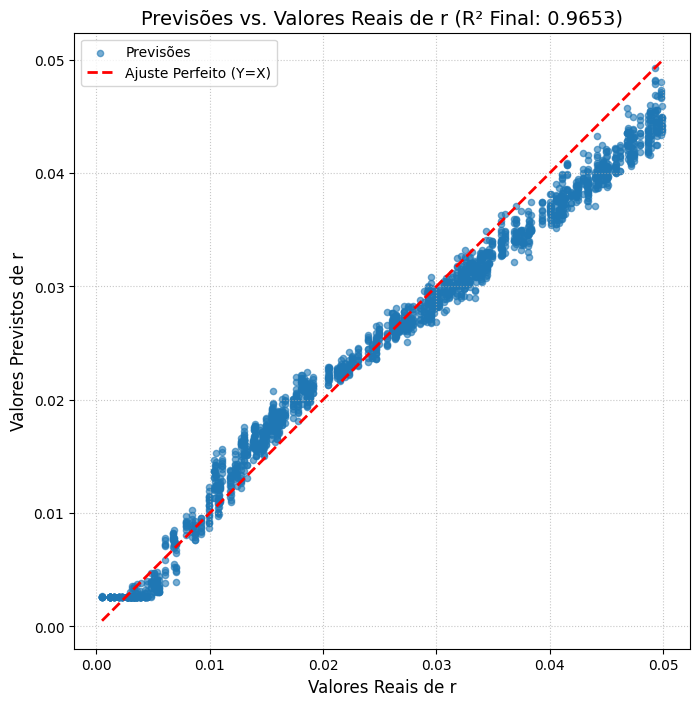

In [30]:
# Crie a linha de identidade X=Y
min_val = min(y_test_2d.min(), y_pred_test_original.min())
max_val = max(y_test_2d.max(), y_pred_test_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_test_2d, y_pred_test_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de r (R² Final: {r2_test:.4f})', fontsize=14)
plt.xlabel('Valores Reais de r', fontsize=12)
plt.ylabel('Valores Previstos de r', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

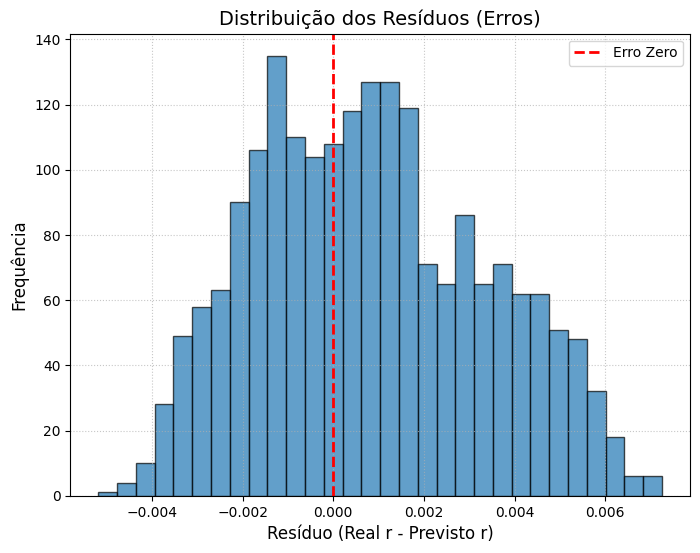

In [31]:


# Calcule os resíduos (True - Predicted)
residuals = y_test_2d - y_pred_test_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real r - Previsto r)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

## 3.4.1 - Visualização com barra de erros

Os dados utilizados associam 10 valores diferentes das features a um mesmo valor do target. O objetivo é simular os ruídos presentes em observações astronômicas.

A visualização com barras de erros também é feita abaixo utilizando-se os dados de teste.

In [32]:
# Criando um DataFrame para facilitar a agregação
# Garantindo que y_train e y_pred_original são 1D para o DataFrame
y_test_flat = y_test_2d.ravel()
y_pred_test_flat = y_pred_test_original.ravel()

df_results = pd.DataFrame({
    'y_test': y_test_flat,
    'y_test_pred': y_pred_test_flat
})

# AGREGAR: Agrupar por 'y_true' e calcular Média e Desvio Padrão para 'y_pred'
# 'y_true' (a variável agrupada) será o índice do novo DataFrame
df_grouped = df_results.groupby('y_test')['y_test_pred'].agg(['mean', 'std']).reset_index()

# Renomear as colunas para clareza
df_grouped.columns = ['y_test', 'y_test_pred_mean', 'y_test_pred_std']

# Cálculo do Resíduo Padronizado (em módulos, conforme solicitado)
# Evite a divisão por zero, substituindo desvios padrão zero por um valor pequeno (ex: 1e-6)
df_grouped['y_test_pred_std_safe'] = df_grouped['y_test_pred_std'].replace(0, 1e-6)
df_grouped['Standardized_Residual'] = (
    np.abs(df_grouped['y_test'] - df_grouped['y_test_pred_mean']) / df_grouped['y_test_pred_std_safe']
)

# Exibir o resultado da agregação (opcional)
print("Dados Agrupados (Exemplo):")
print(df_grouped.head())

Dados Agrupados (Exemplo):
     y_test  y_test_pred_mean  y_test_pred_std  y_test_pred_std_safe  \
0  0.000509          0.002606         0.000042              0.000042   
1  0.001191          0.002592         0.000000              0.000001   
2  0.001256          0.002592         0.000000              0.000001   
3  0.001547          0.002592         0.000000              0.000001   
4  0.001983          0.002592         0.000000              0.000001   

   Standardized_Residual  
0              49.460473  
1            1400.996690  
2            1335.996690  
3            1044.996689  
4             608.996688  


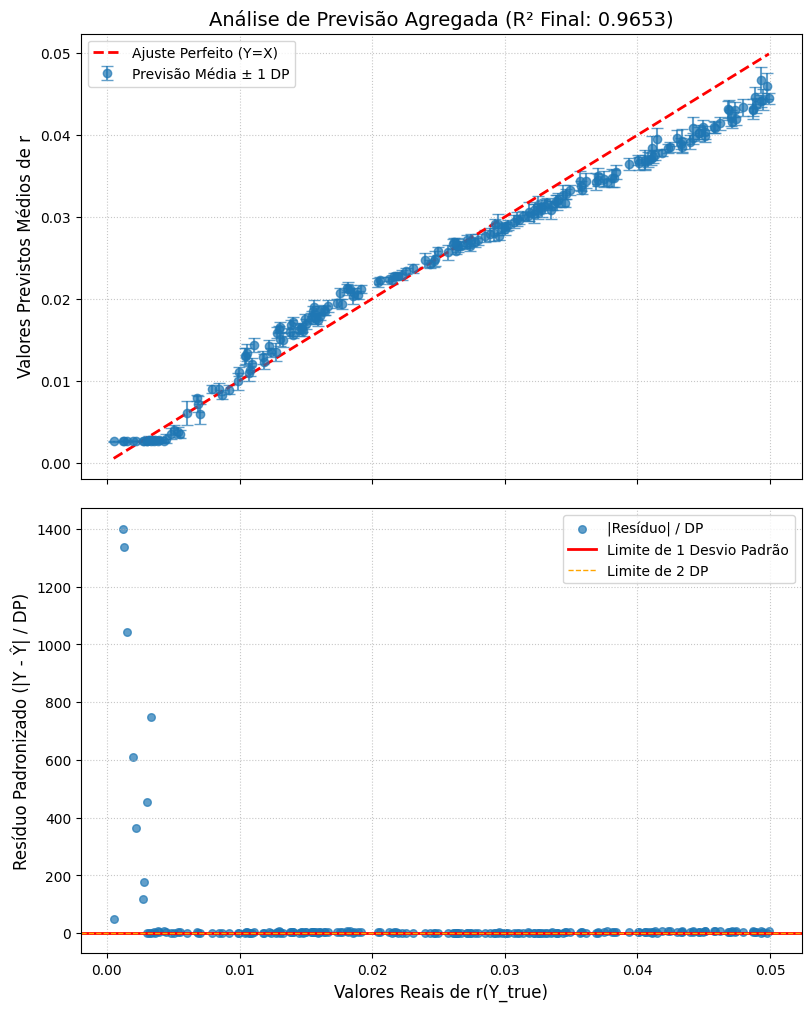

In [33]:
# --- VISUALIZAÇÃO COM GRÁFICO DE DUPLO EIXO ---
# Cria um espaço de figuras com 2 linhas e 1 coluna, compartilhando o eixo X
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 10), 
    sharex=True, # Os dois gráficos compartilham o mesmo eixo X
    gridspec_kw={'hspace': 0.05}, # Reduz o espaço entre os subplots
    constrained_layout=True 
)

# ==========================================================
# GRÁFICO SUPERIOR: Previsão Média vs. Real (Com Barras de Erro)
# ==========================================================

# 1. Plotar os pontos agregados com Barras de Erro
ax1.errorbar(
    x=df_grouped['y_test'],             
    y=df_grouped['y_test_pred_mean'],            
    yerr=df_grouped['y_test_pred_std'],          
    fmt='o',                                
    capsize=4,                              
    alpha=0.7,
    label='Previsão Média ± 1 DP'
)

# 2. Linha de Identidade (Ajuste Perfeito Y=X)
ax1.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

ax1.set_title(f'Análise de Previsão Agregada (R² Final: {r2_test:.4f})', fontsize=14)
ax1.set_ylabel('Valores Previstos Médios de r', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# ==========================================================
# GRÁFICO INFERIOR: Resíduos Padronizados
# ==========================================================

# 1. Scatter Plot dos Resíduos Padronizados
ax2.scatter(
    df_grouped['y_test'], 
    df_grouped['Standardized_Residual'], 
    alpha=0.7, 
    s=30, 
    label='|Resíduo| / DP'
)

# 2. Linha de Referência Crítica (Z-Score = 1.0)
ax2.axhline(
    y=1.0, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Limite de 1 Desvio Padrão'
)
ax2.axhline(y=2.0, color='orange', linestyle='--', linewidth=1, label='Limite de 2 DP')


ax2.set_xlabel('Valores Reais de r(Y_true)', fontsize=12)
ax2.set_ylabel('Resíduo Padronizado (|Y - Ŷ| / DP)', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

plt.show()

# 2 - Modelo com seleção de features não linear

## 2.1 - Selecionando features

In [ ]:
# Checa se o arquivo foi salvo corretamente
with open(caminho_features_selecionadas_non_linear_features, 'rb') as f:
    loaded_data = pickle.load(f)


selected_feature_names = loaded_data['list']

In [ ]:
selected_feature_names

In [ ]:
X_test_non_linear_selection = X_test[selected_feature_names]

In [ ]:
X_test_scaled = X_scaler.fit_transform(X_test_non_linear_selection)

# Escalonamento do Target (Y)
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_test_2d = y_test.values.reshape(-1, 1)
y_test_scaled = y_scaler.fit_transform(y_test_2d)

In [34]:
X_test_scaled

array([[0.07435633, 0.03692665, 0.07820612, ..., 0.67787304, 0.75516848,
        0.58506933],
       [0.0345022 , 0.04971428, 0.16655969, ..., 0.43809408, 0.61857454,
        0.60499934],
       [0.04625197, 0.02367464, 0.03390572, ..., 0.46693009, 0.22309948,
        0.68884533],
       ...,
       [0.05592865, 0.0164072 , 0.03009316, ..., 0.54483773, 0.74733535,
        0.3456188 ],
       [0.00669132, 0.03854449, 0.02475963, ..., 0.37918641, 0.43993221,
        0.2583734 ],
       [0.02253857, 0.03226719, 0.0216271 , ..., 0.57681082, 0.50620491,
        0.50459419]], shape=(2000, 510))

In [35]:
X_test_scaled.max()

np.float64(1.0000000000000002)

In [36]:
X_test_scaled.min()

np.float64(0.0)

## 3.2 - Salvando valores normalizados

As features normalizadas serão necessárias no notebook de explicabilidade dos modelos, por isso salva-se abaixo:

In [ ]:
np.save(caminho_X_test_shap_non_linear_features, X_train_scaled)

np.save(caminho_y_teste_shap_non_linear_features, y_train_scaled)

# 3.3 - Inferência 

In [ ]:
# Carregamento do modelo (usando o caminho verificado)
best_nn_model = joblib.load(caminho_modelo_non_linear_features)

In [ ]:
# A previsão é feita na escala Z-Score (escalada)
y_pred_test_scaled = best_nn_model.predict(X_test_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_test_original = y_scaler.inverse_transform(y_pred_test_scaled)


print("Previsão no Conjunto de Teste concluída com sucesso.")

In [ ]:
X_test_scaled.max()

In [ ]:
y_pred_test_scaled.max()

In [ ]:
X_test_scaled.min()

In [ ]:
y_pred_test_scaled.min()

In [ ]:
y_pred_test_original.max()

In [ ]:
y_pred_test_original.min()

## 3. 4 - Métricas e visualizações

In [ ]:
# Cálculo das 3 Métricas de Avaliação Finais:
mse_test = mean_squared_error(y_test_2d, y_pred_test_original)
rmse_test = root_mean_squared_error(y_test_2d, y_pred_test_original)
mae_test = mean_absolute_error(y_test_2d, y_pred_test_original)
r2_test = r2_score(y_test_2d, y_pred_test_original)

print("\n" + "="*50)
print("AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE")
print("="*50)
print(f"MSE (Erro Quadrático Médio): {mse_test:.8f}")
print(f"RMSE (Erro Absoluto Médio):   {rmse_test:.8f} (Erro médio na unidade de 'r')")
print(f"MAE (Erro Absoluto Médio):   {mae_test:.8f} (Erro médio na unidade de 'r')")
print(f"R2 (Ajuste):                 {r2_test:.4f}")
print("="*50)

In [ ]:
# Crie a linha de identidade X=Y
min_val = min(y_test_2d.min(), y_pred_test_original.min())
max_val = max(y_test_2d.max(), y_pred_test_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_test_2d, y_pred_test_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de r (R² Final: {r2_test:.4f})', fontsize=14)
plt.xlabel('Valores Reais de r', fontsize=12)
plt.ylabel('Valores Previstos de r', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

In [ ]:


# Calcule os resíduos (True - Predicted)
residuals = y_test_2d - y_pred_test_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real r - Previsto r)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

## 3.4.1 - Visualização com barra de erros

Os dados utilizados associam 10 valores diferentes das features a um mesmo valor do target. O objetivo é simular os ruídos presentes em observações astronômicas.

A visualização com barras de erros também é feita abaixo utilizando-se os dados de teste.

In [ ]:
# Criando um DataFrame para facilitar a agregação
# Garantindo que y_train e y_pred_original são 1D para o DataFrame
y_test_flat = y_test_2d.ravel()
y_pred_test_flat = y_pred_test_original.ravel()

df_results = pd.DataFrame({
    'y_test': y_test_flat,
    'y_test_pred': y_pred_test_flat
})

# AGREGAR: Agrupar por 'y_true' e calcular Média e Desvio Padrão para 'y_pred'
# 'y_true' (a variável agrupada) será o índice do novo DataFrame
df_grouped = df_results.groupby('y_test')['y_test_pred'].agg(['mean', 'std']).reset_index()

# Renomear as colunas para clareza
df_grouped.columns = ['y_test', 'y_test_pred_mean', 'y_test_pred_std']

# Cálculo do Resíduo Padronizado (em módulos, conforme solicitado)
# Evite a divisão por zero, substituindo desvios padrão zero por um valor pequeno (ex: 1e-6)
df_grouped['y_test_pred_std_safe'] = df_grouped['y_test_pred_std'].replace(0, 1e-6)
df_grouped['Standardized_Residual'] = (
    np.abs(df_grouped['y_test'] - df_grouped['y_test_pred_mean']) / df_grouped['y_test_pred_std_safe']
)

# Exibir o resultado da agregação (opcional)
print("Dados Agrupados (Exemplo):")
print(df_grouped.head())

In [ ]:
# --- VISUALIZAÇÃO COM GRÁFICO DE DUPLO EIXO ---
# Cria um espaço de figuras com 2 linhas e 1 coluna, compartilhando o eixo X
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 10), 
    sharex=True, # Os dois gráficos compartilham o mesmo eixo X
    gridspec_kw={'hspace': 0.05}, # Reduz o espaço entre os subplots
    constrained_layout=True 
)

# ==========================================================
# GRÁFICO SUPERIOR: Previsão Média vs. Real (Com Barras de Erro)
# ==========================================================

# 1. Plotar os pontos agregados com Barras de Erro
ax1.errorbar(
    x=df_grouped['y_test'],             
    y=df_grouped['y_test_pred_mean'],            
    yerr=df_grouped['y_test_pred_std'],          
    fmt='o',                                
    capsize=4,                              
    alpha=0.7,
    label='Previsão Média ± 1 DP'
)

# 2. Linha de Identidade (Ajuste Perfeito Y=X)
ax1.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

ax1.set_title(f'Análise de Previsão Agregada (R² Final: {r2_test:.4f})', fontsize=14)
ax1.set_ylabel('Valores Previstos Médios de r', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# ==========================================================
# GRÁFICO INFERIOR: Resíduos Padronizados
# ==========================================================

# 1. Scatter Plot dos Resíduos Padronizados
ax2.scatter(
    df_grouped['y_test'], 
    df_grouped['Standardized_Residual'], 
    alpha=0.7, 
    s=30, 
    label='|Resíduo| / DP'
)

# 2. Linha de Referência Crítica (Z-Score = 1.0)
ax2.axhline(
    y=1.0, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Limite de 1 Desvio Padrão'
)
ax2.axhline(y=2.0, color='orange', linestyle='--', linewidth=1, label='Limite de 2 DP')


ax2.set_xlabel('Valores Reais de r(Y_true)', fontsize=12)
ax2.set_ylabel('Resíduo Padronizado (|Y - Ŷ| / DP)', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

plt.show()

# 4 - Sugestões para trabalhos futuros

- Criar novas features com os dados de entrada.

- Aumentar a rede de parâmetros da validação cruzada.

# 3 - Modelo com seleção linear de features

## 3.1 - Selecionando features

In [ ]:
# Checa se o arquivo foi salvo corretamente
with open(caminho_features_selecionadas_linear_features, 'rb') as f:
    loaded_data = pickle.load(f)


selected_feature_names = loaded_data['list']

In [ ]:
selected_feature_names

In [ ]:
X_test_linear_selection = X_test[selected_feature_names]

In [ ]:
X_test_scaled = X_scaler.fit_transform(X_test_linear_selection)

# Escalonamento do Target (Y)
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_test_2d = y_test.values.reshape(-1, 1)
y_test_scaled = y_scaler.fit_transform(y_test_2d)

In [ ]:
X_test_scaled

In [ ]:
X_test_scaled.max()

In [ ]:
X_test_scaled.min()

## 3.2 - Salvando valores normalizados

As features normalizadas serão necessárias no notebook de explicabilidade dos modelos, por isso salva-se abaixo:

In [ ]:
np.save(caminho_X_test_shap_linear_features, X_train_scaled)

np.save(caminho_y_teste_shap_linear_features, y_train_scaled)

# 3.3 - Inferência 

In [ ]:
# Carregamento do modelo (usando o caminho verificado)
best_nn_model = joblib.load(caminho_modelo_linear_features)

In [ ]:
# A previsão é feita na escala Z-Score (escalada)
y_pred_test_scaled = best_nn_model.predict(X_test_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_test_original = y_scaler.inverse_transform(y_pred_test_scaled)


print("Previsão no Conjunto de Teste concluída com sucesso.")

In [ ]:
X_test_scaled.max()

In [ ]:
y_pred_test_scaled.max()

In [ ]:
X_test_scaled.min()

In [ ]:
y_pred_test_scaled.min()

In [ ]:
y_pred_test_original.max()

In [ ]:
y_pred_test_original.min()

## 3. 4 - Métricas e visualizações

In [ ]:
# Cálculo das 3 Métricas de Avaliação Finais:
mse_test = mean_squared_error(y_test_2d, y_pred_test_original)
rmse_test = root_mean_squared_error(y_test_2d, y_pred_test_original)
mae_test = mean_absolute_error(y_test_2d, y_pred_test_original)
r2_test = r2_score(y_test_2d, y_pred_test_original)

print("\n" + "="*50)
print("AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE")
print("="*50)
print(f"MSE (Erro Quadrático Médio): {mse_test:.8f}")
print(f"RMSE (Erro Absoluto Médio):   {rmse_test:.8f} (Erro médio na unidade de 'r')")
print(f"MAE (Erro Absoluto Médio):   {mae_test:.8f} (Erro médio na unidade de 'r')")
print(f"R2 (Ajuste):                 {r2_test:.4f}")
print("="*50)

In [ ]:
# Crie a linha de identidade X=Y
min_val = min(y_test_2d.min(), y_pred_test_original.min())
max_val = max(y_test_2d.max(), y_pred_test_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_test_2d, y_pred_test_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de r (R² Final: {r2_test:.4f})', fontsize=14)
plt.xlabel('Valores Reais de r', fontsize=12)
plt.ylabel('Valores Previstos de r', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

In [ ]:


# Calcule os resíduos (True - Predicted)
residuals = y_test_2d - y_pred_test_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real r - Previsto r)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

## 3.4.1 - Visualização com barra de erros

Os dados utilizados associam 10 valores diferentes das features a um mesmo valor do target. O objetivo é simular os ruídos presentes em observações astronômicas.

A visualização com barras de erros também é feita abaixo utilizando-se os dados de teste.

In [ ]:
# Criando um DataFrame para facilitar a agregação
# Garantindo que y_train e y_pred_original são 1D para o DataFrame
y_test_flat = y_test_2d.ravel()
y_pred_test_flat = y_pred_test_original.ravel()

df_results = pd.DataFrame({
    'y_test': y_test_flat,
    'y_test_pred': y_pred_test_flat
})

# AGREGAR: Agrupar por 'y_true' e calcular Média e Desvio Padrão para 'y_pred'
# 'y_true' (a variável agrupada) será o índice do novo DataFrame
df_grouped = df_results.groupby('y_test')['y_test_pred'].agg(['mean', 'std']).reset_index()

# Renomear as colunas para clareza
df_grouped.columns = ['y_test', 'y_test_pred_mean', 'y_test_pred_std']

# Cálculo do Resíduo Padronizado (em módulos, conforme solicitado)
# Evite a divisão por zero, substituindo desvios padrão zero por um valor pequeno (ex: 1e-6)
df_grouped['y_test_pred_std_safe'] = df_grouped['y_test_pred_std'].replace(0, 1e-6)
df_grouped['Standardized_Residual'] = (
    np.abs(df_grouped['y_test'] - df_grouped['y_test_pred_mean']) / df_grouped['y_test_pred_std_safe']
)

# Exibir o resultado da agregação (opcional)
print("Dados Agrupados (Exemplo):")
print(df_grouped.head())

In [ ]:
# --- VISUALIZAÇÃO COM GRÁFICO DE DUPLO EIXO ---
# Cria um espaço de figuras com 2 linhas e 1 coluna, compartilhando o eixo X
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 10), 
    sharex=True, # Os dois gráficos compartilham o mesmo eixo X
    gridspec_kw={'hspace': 0.05}, # Reduz o espaço entre os subplots
    constrained_layout=True 
)

# ==========================================================
# GRÁFICO SUPERIOR: Previsão Média vs. Real (Com Barras de Erro)
# ==========================================================

# 1. Plotar os pontos agregados com Barras de Erro
ax1.errorbar(
    x=df_grouped['y_test'],             
    y=df_grouped['y_test_pred_mean'],            
    yerr=df_grouped['y_test_pred_std'],          
    fmt='o',                                
    capsize=4,                              
    alpha=0.7,
    label='Previsão Média ± 1 DP'
)

# 2. Linha de Identidade (Ajuste Perfeito Y=X)
ax1.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

ax1.set_title(f'Análise de Previsão Agregada (R² Final: {r2_test:.4f})', fontsize=14)
ax1.set_ylabel('Valores Previstos Médios de r', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# ==========================================================
# GRÁFICO INFERIOR: Resíduos Padronizados
# ==========================================================

# 1. Scatter Plot dos Resíduos Padronizados
ax2.scatter(
    df_grouped['y_test'], 
    df_grouped['Standardized_Residual'], 
    alpha=0.7, 
    s=30, 
    label='|Resíduo| / DP'
)

# 2. Linha de Referência Crítica (Z-Score = 1.0)
ax2.axhline(
    y=1.0, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Limite de 1 Desvio Padrão'
)
ax2.axhline(y=2.0, color='orange', linestyle='--', linewidth=1, label='Limite de 2 DP')


ax2.set_xlabel('Valores Reais de r(Y_true)', fontsize=12)
ax2.set_ylabel('Resíduo Padronizado (|Y - Ŷ| / DP)', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

plt.show()

# 4 - Sugestões para trabalhos futuros

- Criar novas features com os dados de entrada.

- Aumentar a rede de parâmetros da validação cruzada.